## Individual runs

In [367]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from model import PolicyModel

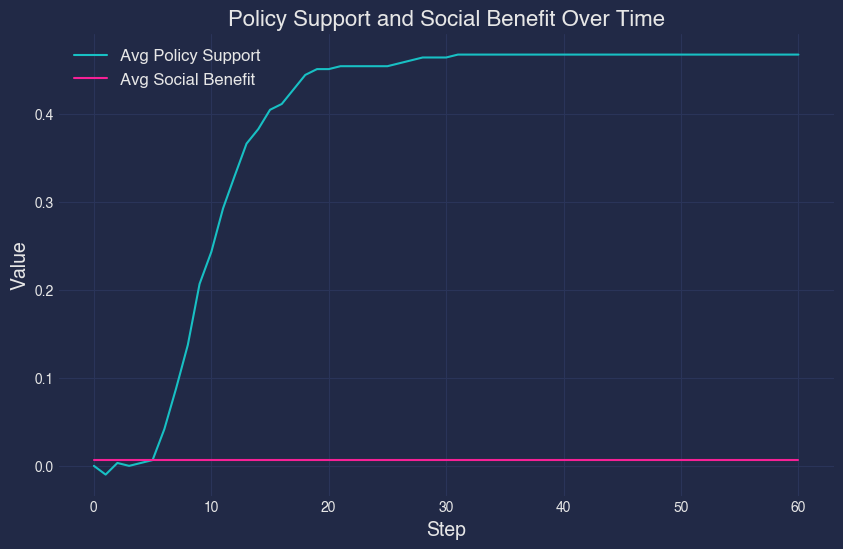

In [387]:
# Set up and run the model
my_model = PolicyModel(
    num_agents=140,               # Number of agents in the model
    privileged_fraction=0.1,      # Fraction of privileged nodes
    marginalized_fraction=0.3,    # Fraction of marginalized nodes
    rel_policy_expansion=0.02,    # Relative policy expansion rate
    policy_impact_bias_pro_marginalized=0.55,       # Bias of policy impact toward marginalized
    trigger_level=0.45,           # Trigger level for policy maker to double down
    policy_reaction=False,        # Whether policymaker doubles doen and expands policy
)

steps = 60

# Run the model for the specified number of steps
for i in range(steps):
    print(f"now running step {i}", end="\r", flush=True)
    # for n in my_model.agents:
    #   print(f"{n} opinion is {n.opinion}")
    my_model.step()

# Collect and visualize the results
data = my_model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(data["Avg Policy Support"], label="Avg Policy Support")
plt.plot(data["Avg Social Benefit"], label="Avg Social Benefit")
plt.title("Policy Support and Social Benefit Over Time", fontsize=16)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [369]:
# Count agents by category
marginalized_agents = sum(1 for agent in my_model.agents if agent.marginalized)
privileged_agents = sum(1 for agent in my_model.agents if agent.privileged)
marginalized_impacted = sum(1 for agent in my_model.agents if agent.marginalized and agent.impact != 0)
privileged_impacted = sum(1 for agent in my_model.agents if agent.privileged and agent.impact != 0)

# Print metrics
print(f"Marginalized agents: {marginalized_agents}")
print(f"Privileged agents: {privileged_agents}")
print(f"Marginalized agents impacted: {marginalized_impacted}")
print(f"Privileged agents impacted: {privileged_impacted}")

Marginalized agents: 42
Privileged agents: 14
Marginalized agents impacted: 2
Privileged agents impacted: 1


## Batch Run and Visualization

In [333]:
import numpy as np
import pandas as pd
import mesa

parameters = {
    'num_agents': 300,  # Number of agents in the model
    'privileged_fraction': 0.1,  # Fraction of privileged nodes
    'marginalized_fraction': 0.3,  # Fraction of marginalized nodes
    'rel_policy_expansion': np.linspace(0.01, 0.02, 20),  # Relative policy expansion rate
    'policy_impact_bias_pro_marginalized': np.linspace(0.5, 0.55, 10),  # Bias of policy impact toward marginalized
    'trigger_level': 0.45,  # Trigger level for policy maker to double down
    'policy_reaction': False,  # Whether policymaker doubles down and expands policy
}

results = mesa.batch_run(
  PolicyModel,
  parameters=parameters,
  iterations=10,
  max_steps=60,
  number_processes=12,
  data_collection_period=1,
  display_progress=True,
)

results_df = pd.DataFrame(results)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [378]:
results_df.to_csv('results/results.csv', index=False)

In [379]:
results_df = pd.read_csv('results/results.csv')

In [380]:
# Check original number of rows
print(f"Original number of rows: {len(results_df)}")

# Filter the DataFrame
results_df_filtered = results_df[results_df['rel_policy_expansion'].round(3) == 0.011]

# Check number of rows after filtering
print(f"Number of rows after filtering: {len(results_df_filtered)}")

# Additional verification of the filtering
print("\nUnique values in rel_policy_expansion column of filtered DataFrame:")
print(results_df_filtered['rel_policy_expansion'].unique())

Original number of rows: 122000
Number of rows after filtering: 12200

Unique values in rel_policy_expansion column of filtered DataFrame:
[0.01052632 0.01105263]


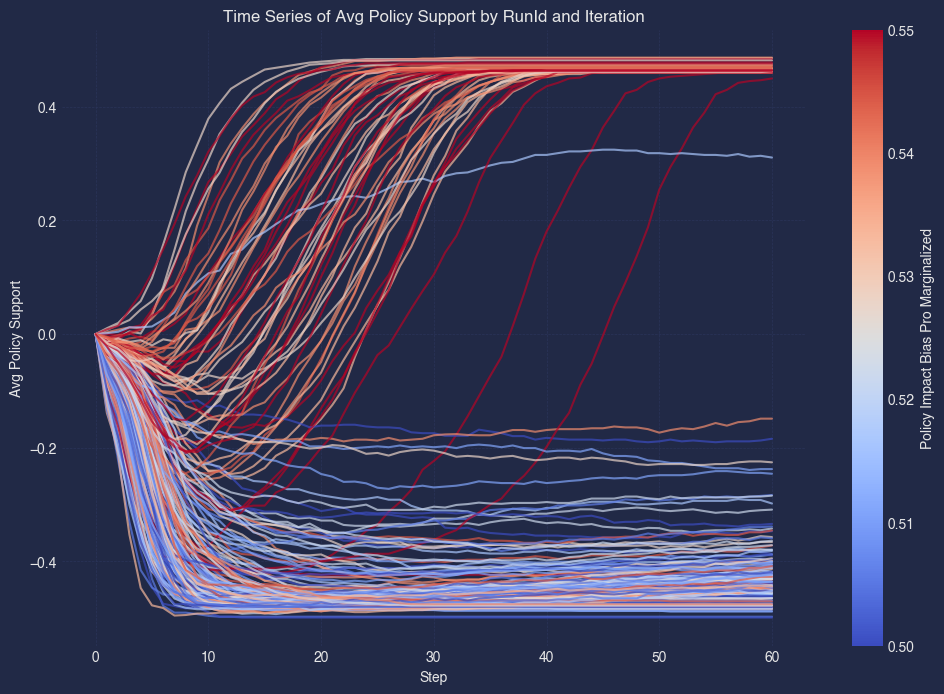

In [394]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size and create axes

# Normalize the policy_impact_bias_pro_marginalized values
norm = plt.Normalize(
    results_df_filtered['policy_impact_bias_pro_marginalized'].min(), 
    results_df_filtered['policy_impact_bias_pro_marginalized'].max()
)

# Create a colormap
cmap = plt.get_cmap('coolwarm')  # You can choose any other colormap

# Iterate over each unique combination of RunId and iteration
for (run_id, iteration), group in results_df_filtered.groupby(['RunId', 'iteration']):
    color = cmap(norm(group['policy_impact_bias_pro_marginalized'].iloc[0]))  # Use the first value since it's constant for the group
    ax.plot(group['Step'], group['Avg Policy Support'], alpha=0.7, color=color)

# Add labels and title to the axes
ax.set_xlabel('Step')
ax.set_ylabel('Avg Policy Support')
ax.set_title('Time Series of Avg Policy Support by RunId and Iteration')

# Show grid on the axes
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Use ax=ax to associate the colorbar with the axes
cbar.ax.set_ylabel('Policy Impact Bias Pro Marginalized')

# Display the plot
plt.show()

In [388]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider


def plot_interactive(rel_policy_expansion):
    # Filter the dataframe based on the rel_policy_expansion value
    filtered_df = results_df[results_df['rel_policy_expansion'].round(3) == round(rel_policy_expansion, 3)]
    
    if filtered_df.empty:
        print(f"No data found for rel_policy_expansion = {rel_policy_expansion:.3f}")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size and create axes

    plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")

    # Normalize the policy_impact_bias_pro_marginalized values
    norm = plt.Normalize(
        filtered_df['policy_impact_bias_pro_marginalized'].min(), 
        filtered_df['policy_impact_bias_pro_marginalized'].max()
    )

    # Create a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any other colormap

    # Iterate over each unique combination of RunId and iteration
    for (run_id, iteration), group in filtered_df.groupby(['RunId', 'iteration']):
        color = cmap(norm(group['policy_impact_bias_pro_marginalized'].iloc[0]))  # Use the first value since it's constant for the group
        ax.plot(group['Step'], group['Avg Policy Support'], alpha=0.7, color=color)

    # Add labels and title to the axes
    ax.set_xlabel('Step')
    ax.set_ylabel('Avg Policy Support')
    ax.set_title(f'Time Series of Avg Policy Support by RunId and Iteration (rel_policy_expansion = {rel_policy_expansion:.3f})')

    # Show grid on the axes
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Add a colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)  # Use ax=ax to associate the colorbar with the axes
    cbar.ax.set_ylabel('Policy Impact Bias Pro Marginalized')

    # Display the plot
    plt.show()

# Create an interactive slider for rel_policy_expansion
rel_policy_expansion_slider = FloatSlider(
    value=0.015,  # Initial value
    min=0.01,
    max=0.02,
    step=0.001,
    description='rel_policy_expansion:',
    readout_format='.3f'
)

# Use interact to create the interactive plot
interact(plot_interactive, rel_policy_expansion=rel_policy_expansion_slider)

interactive(children=(FloatSlider(value=0.015, description='rel_policy_expansion:', max=0.02, min=0.01, readou…

<function __main__.plot_interactive(rel_policy_expansion)>